In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys
import os
sys.path.insert(0, os.path.join('..','src'))
import numpy as np
import pandas as pd

In [3]:
from preprocess import extract_roi

In [4]:
extractor = extract_roi.ExtractROI()

In [5]:
extractor.set_image_with_png('../data/raw/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png')

In [25]:
nogo = np.loadtxt('../data/roi/table_roi_center_train_information.txt', skiprows=1)

In [176]:
files = os.listdir('../data/roi/train/')

In [177]:
files

['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552_roi_center_train_information.txt',
 '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1_roi_center_train_information.txt',
 '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e_roi_center_train_information.txt',
 '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed_roi_center_train_information.txt',
 '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf_roi_center_train_information.txt',
 '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21_roi_center_train_information.txt',
 '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426_roi_center_train_information.txt',
 '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339_roi_center_train_information.txt',
 '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776_roi_center_train_information.txt',
 '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe_roi_center_trai

In [178]:
roi = []
sizes = []
category = []
for f in files:
    if '.npy' in f:
        if 'mask' in f:
            continue
        elif 'NEG' in f:
            data = np.load('../data/roi/train/'+f)
            roi.append(data)
            sizes.append(data.shape)
            category.append(0)
        else:
            data = np.load('../data/roi/train/'+f)
            roi.append(data)
            sizes.append(data.shape)
            category.append(1)

In [179]:
roi_df = pd.DataFrame(list(zip(roi, sizes, category)), columns=['image_matrix', 'sizes', 'is_positive'])

In [180]:
roi_df.to_pickle('../data/roi/train/roi_dataframe.pkl')

In [74]:
sys.path.insert(0, os.path.join('..','scripts'))


In [75]:
import train_svm_classifier

In [277]:
import importlib
importlib.reload(train_svm_classifier)

<module 'train_svm_classifier' from '..\\scripts\\train_svm_classifier.py'>

In [135]:
df_path = os.path.join('..', 'data', 'roi', 'train', 'roi_dataframe.pkl')

In [136]:
fixed_size = (64, 64)
classifier_output = os.path.join( '..', 'models', 'svm_rbf_smallset.pkl' ) # name of which classifier will be saved as
kernel = 'rbf' # rbf (radial basis function), linear, poly, sigmoid
gamma = 0.001 # kernel coefficient (specify as 'auto' if unsure)
C = 1 

In [137]:
classifier = train_svm_classifier.train_classifier(df_path, 'image_matrix', 'is_positive', 'sizes',  fixed_size, 
                                                   classifier_output, kernel, gamma, C)

In [181]:
rizedroi = roi_df[roi_df['image_matrix'].apply(np.shape) == (64,64,3)]

In [140]:
from analysis import hog_classifier

In [159]:
importlib.reload(hog_classifier)

<module 'analysis.hog_classifier' from '..\\src\\analysis\\hog_classifier.py'>

In [160]:
features = pd.DataFrame(hog_classifier.feature_extraction(classifier.data, 'image_matrix') )

In [161]:
len(features)

557

In [167]:
target = pd.DataFrame(np.repeat([True], len(features)))
target[classifier.data[classifier.category_col_name].values == 0] = False

In [169]:
import sklearn

In [171]:
classifier = sklearn.svm.SVC( kernel=classifier.kernel, gamma=classifier.gamma, C=classifier.C, verbose=True )

In [172]:
classifier.fit( features, target.values.ravel() )

[LibSVM]

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

In [182]:
files = os.listdir('../data/roi/test/')

In [183]:
roi = []
sizes = []
category = []
for f in files:
    if '.npy' in f:
        if 'mask' in f:
            continue
        elif 'NEG' in f:
            data = np.load('../data/roi/test/'+f)
            roi.append(data)
            sizes.append(data.shape)
            category.append(0)
        else:
            data = np.load('../data/roi/test/'+f)
            roi.append(data)
            sizes.append(data.shape)
            category.append(1)

In [184]:
test_df = pd.DataFrame(list(zip(roi, sizes, category)), columns=['image_matrix', 'sizes', 'is_positive'])

In [228]:
test_df.to_pickle('../data/roi/test/test_roi_dataframe.pkl')

In [189]:
test = [True, False, True]

In [190]:
sum(test)

2

In [3]:
train_df = pd.read_pickle('../data/roi/train/train_dataframe.pkl')
pos_example = train_df[train_df.is_positive.values == '1']

In [4]:
train_neg32_df = pd.read_pickle('../data/roi/neg_32/train_dataframe.pkl')
neg_example = train_neg32_df[train_neg32_df.is_positive.values == '0']

In [5]:
np.random.seed(200)

In [6]:
index_to_use = np.random.permutation(len(pos_example))

In [7]:
portion = int(0.1*len(pos_example))

In [8]:
small_train_roi = pd.concat([pos_example.iloc[index_to_use[:portion]],
                            neg_example.iloc[index_to_use[:portion]]],
                           ignore_index=True)
train_roi = pd.concat([pos_example, neg_example], ignore_index=True)

In [9]:
small_train_roi.to_pickle('../data/roi/train/p10_train_neg32_dataframe.pkl')
train_roi.to_pickle('../data/roi/train/train_neg32_dataframe.pkl')

In [222]:
small_train_roi.head()

,filename,parent_image_id,extract_width,extract_height,image_width,image_height,index_col,index_row,is_positive,image_matrix
0,pos_29dd28df98ee51b4ab1a87f5509538ecc3e4697fc5...,29dd28df98ee51b4ab1a87f5509538ecc3e4697fc57c40...,64,64,256,256,116,153,1,"[[[2, 2, 2], [3, 3, 3], [3, 3, 3], [3, 3, 3], ..."
1,pos_a246bcaa64af48ee5ca181cd594c0fc43466e76144...,a246bcaa64af48ee5ca181cd594c0fc43466e7614406eb...,60,43,256,256,27,10,1,"[[[3, 3, 3], [2, 2, 2], [2, 2, 2], [3, 3, 3], ..."
2,pos_29780b28e6a75fac7b96f164a1580666513199794f...,29780b28e6a75fac7b96f164a1580666513199794f1b19...,64,64,256,256,154,173,1,"[[[11, 11, 11], [12, 12, 12], [12, 12, 12], [1..."
3,pos_4bf6a5ec42032bb8dbbb10d25fdc5211b2fe1ce44b...,4bf6a5ec42032bb8dbbb10d25fdc5211b2fe1ce44b6e57...,64,64,256,256,71,70,1,"[[[13, 13, 13], [13, 13, 13], [12, 12, 12], [1..."
4,pos_64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa11...,64eeef16fdc4e26523d27bfa71a1d38d2cb2e4fa116c0d...,56,64,256,256,231,127,1,"[[[20, 20, 20], [18, 18, 18], [17, 17, 17], [1..."


In [10]:
test_df = pd.read_pickle('../data/roi/test/test_dataframe.pkl')
pos_example = test_df[test_df.is_positive.values == '1']

In [11]:
test_neg32_df = pd.read_pickle('../data/roi/neg_32/test_dataframe.pkl')
neg_example = test_neg32_df[test_neg32_df.is_positive.values == '0']

In [12]:
index_to_use = np.random.permutation(len(pos_example))

In [13]:
portion = int(0.1*len(pos_example))

In [14]:
small_test_roi = pd.concat([pos_example.iloc[index_to_use[:portion]],
                            neg_example.iloc[index_to_use[:portion]]],
                           ignore_index=True)
test_roi = pd.concat([pos_example, neg_example], ignore_index=True)
small_test_roi.to_pickle('../data/roi/test/p10_test_neg32_dataframe.pkl')
test_roi.to_pickle('../data/roi/test/test_neg32_dataframe.pkl')

In [272]:
small_train_roi.isnull().sum().sum()

0

In [274]:
df_path = os.path.join('..', 'data', 'roi', 'train', 'small_train_roi_dataframe.pkl')

In [275]:
fixed_size = (64, 64, 3)
classifier_output = os.path.join( '..', 'models', 'svm_rbf_smallset.pkl' ) # name of which classifier will be saved as
kernel = 'rbf' # rbf (radial basis function), linear, poly, sigmoid
gamma = 0.001 # kernel coefficient (specify as 'auto' if unsure)
C = 1 

In [278]:
classifier = train_svm_classifier.train_classifier( df_path, 'image_matrix', 'is_positive', fixed_size, classifier_output,
                             kernel, gamma, C )

In [285]:
sum(classifier.data.is_positive.values == '0')

1915

In [286]:
features = pd.DataFrame(hog_classifier.feature_extraction(classifier.data,
                                                         image_col_name='image_matrix'))

In [292]:
features.isnull().sum().sum()

0

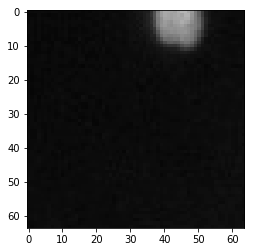

In [312]:
plt.imshow(neg_example.iloc[170].image_matrix)

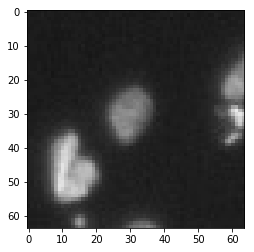

In [313]:
plt.imshow(pos_example.iloc[170].image_matrix)